# What is driving the errors in Zestimates?

---

By: Alejandro Garcia
<br>
Date: April 8, 2022

---

## Project Goals

The goal of this project is to identify drivers of logerror in the Zillow property value estimates and produce a model for predicting the logerror using these drivers.

---

## Project Description

Zillow is interested in identifying what attributes are driving the logerror in their Zestimates. This is important to help produce better prediction models so that Zillow can remain competitive in the housing market. With this in mind we are interested in producing a model for predicting logerror and identifying actionable recommendations that could help reduce the overall average logerror. Additionally, we are interested in single family/single unit properties with transactions in 2017.

---

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn and sklearn installed on your computer.

In [1]:
# Here we are importing everything needed to execute the code blocks in this notebook.
from acquire import AcquireZillow
from prepare import prepare_and_split
from explore import *
from model import *
from preprocessing import scale_data, remove_outliers

# We would like to ignore any warnings that may be provided by our libraries.
import warnings
warnings.filterwarnings("ignore")

---

## Data Acquisition and Preparation

The data is acquired from data.codeup.com using a SQL query. Acquiring the data takes some time so it is cached in a local "zillow.csv" file for quicker access in the future. The "zillow.csv" file is not stored in the Github repository.

We are interested in properties that had a transaction in 2017. For any properties with more than one transaction we only want the most recent transaction. All this is done in SQL. We also want all attributes for each property except for any foreign key columns. ~77,000 observations are retrieved.

**Missing Values:**
<br>
Initial analysis of the data reveals that there is a large amount of missing values. The goal was to keep the preparation simple due to time constraints, so we simply drop all the nulls. However, in order to prevent a large loss of data we do this in two steps:
    - Remove any columns that are missing more than 20% of values.
    - Remove any rows with a missing value.
This results in a loss of ~13,000 observations which was deemed acceptable since we still had more than 80% of the data. This also results in a loss of roughly half of the features present in the data.

**Single Family/Single Unit Properties:**
<br>
We are also only interested in single family/single unit properties. To do this we remove any properties where the property type description is not one of the following: Single Family Residential, Condominium, Cluster Home, Mobile Home, Manufactured Home, and Townhouse.

In [2]:
# Here we will acquire, prepare, and split the zillow property data and store the results in our train, validate, 
# and test dataframes. Details can be found in the prepare.py file.
train, validate, test = prepare_and_split(AcquireZillow().get_data())

We will also need scaled data when building the machine learning models so we will create separate dataframes for the scaled data.

In [3]:
# Here we will scale all of our data except for the target variable logerror.
# We must also not scale yearbuilt_binned since this is not a numeric type.
# The data is scaled using a MinMaxScaler.
train_scaled, validate_scaled, test_scaled = scale_data(
    train,
    validate,
    test,
    train.drop(columns = ['logerror', 'yearbuilt_binned']).columns
)

---

## Exploratory Analysis

With the data prepared and split we can begin exploring the data to identify which features will be most useful for predicting logerror.

In the visualizations below we aim to answer some questions about the data. Details about how these visualization are created can be found in the explore.py file.

### Is there a relationship between tax assessed value and logerror?

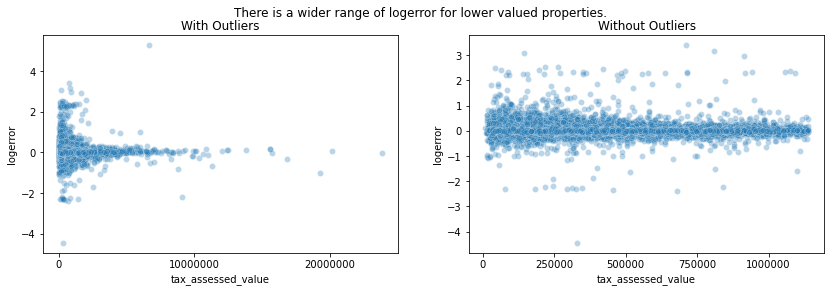

In [4]:
# Here we will plot tax assessed value vs. logerror.
# On the left is the chart with outliers,
# on the right is the chart without outliers.
plot_tax_value_and_logerror(train)

We will run a statistical test to determine if we reject or fail to reject the following null hypothesis:

$H_0$: The mean logerror for properties with tax assessed value less than 400,000 is equal to the mean logerror for properties with tax assessed value greater than 400,000.
<br>
$H_a$: The mean logerror for properties with tax assessed value less than 400,000 is not equal to the mean logerror for properties with tax assessed value greater than 400,000.

In [5]:
# Here we will perform a two sample t-test between properties with tax assessed value less than $400,000
# and properties with tax assessed value greater than $400,000 comparing the mean logerror.
run_stats_test_for_tax_value(train)

Reject H0


The null hypothesis is rejected which indicates that there is a significant difference in mean logerror between properties with tax assessed value less than 400,000 and those with tax assessed value greater than 400,000. There is roughly 50% of properties in each independent sample.

### Does mean logerror vary between different zip codes?

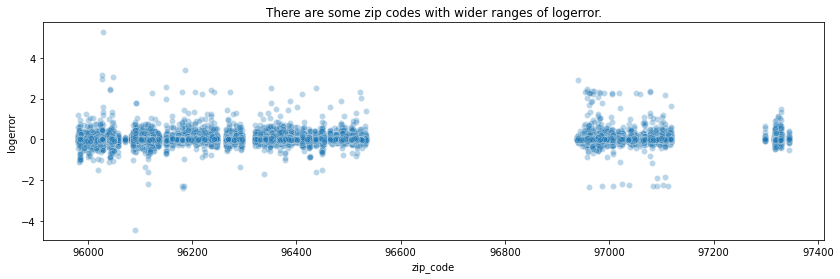

In [6]:
# Here we will visualize the zip codes vs. logerror.
plot_zip_code_and_logerror(train)

We are going to run a statistical test for each zip code to determine if we reject or fail to reject the following null hypothesis:

$H_0$: The mean log error for zip code x (where x is a zip code in the data) is equal to the overall mean logerror.
<br>
$H_a$: The mean log error for zip code x (where x is a zip code in the data) is not equal to the overall mean logerror.

In [7]:
# Here we run one sample t-tests between the mean logerror of each zip code and the overall
# mean logerror.

run_stats_test_for_zip_codes(train)

43 / 383 zip codes have mean log error significantly different than the overall mean log error.


These zip codes account for 13% of all properties.

### Is there a relationship between the size of a property and logerror?

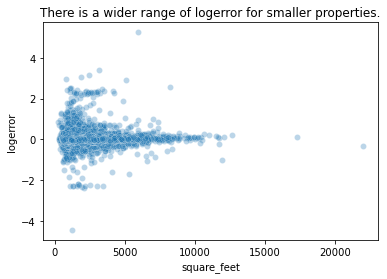

In [8]:
# Here we will visualize square_feet vs. logerror.
plot_square_feet_and_logerror(train)

We will now run a statistical test to determine if smaller properties have a significantly different mean logerror than larger properties.

$H_0$: The mean logerror for properties with less than 2000 square feet is equal to the overall mean logerror.
<br>
$H_a$: The mean logerror for properties with less than 2000 square feet is not equal to the overall mean logerror.

In [9]:
# Here we will run a one sample t-test between the mean logerror of properties with less 
# than 2000 square feet and the overall mean logerror.
run_stats_test_for_square_feet(train)

Reject H0


We reject the null hypothesis meaning there is a significant difference in mean logerror between properties with less than 2000 square feet and the overall mean logerror. This sample accounts for roughly 70% of all properties.

### What is the relationship between the age of a property and the property size?

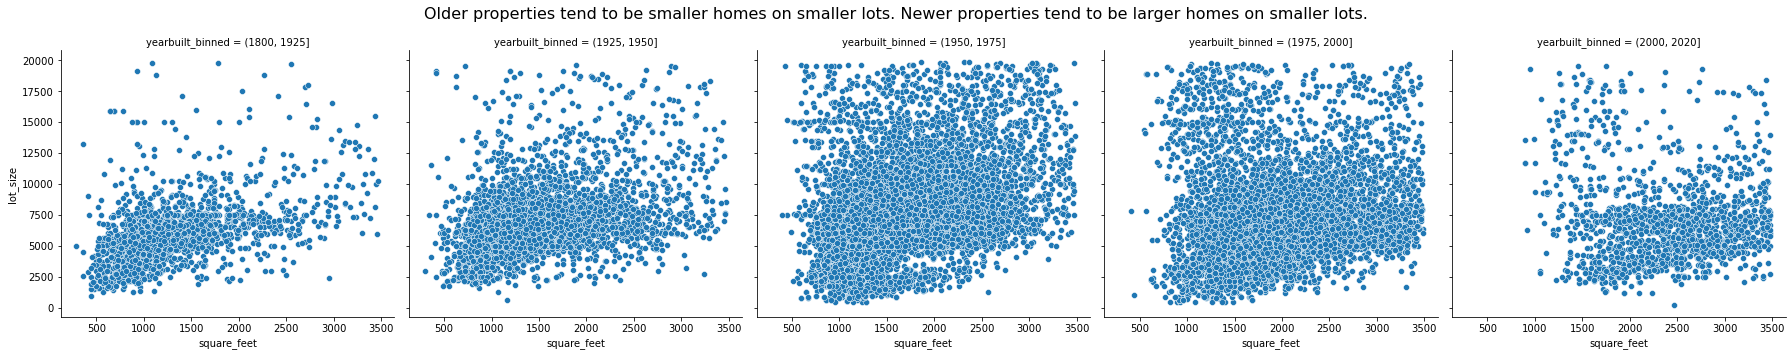

In [10]:
# Here we will plot square_feet vs. lot_size and create a separate chart for each five group of property age.
plot_property_size_and_property_age(train)

With this in mind we can try to build clusters using the property age, square feet, and lot size features. Below are the results. Four clusters are created.

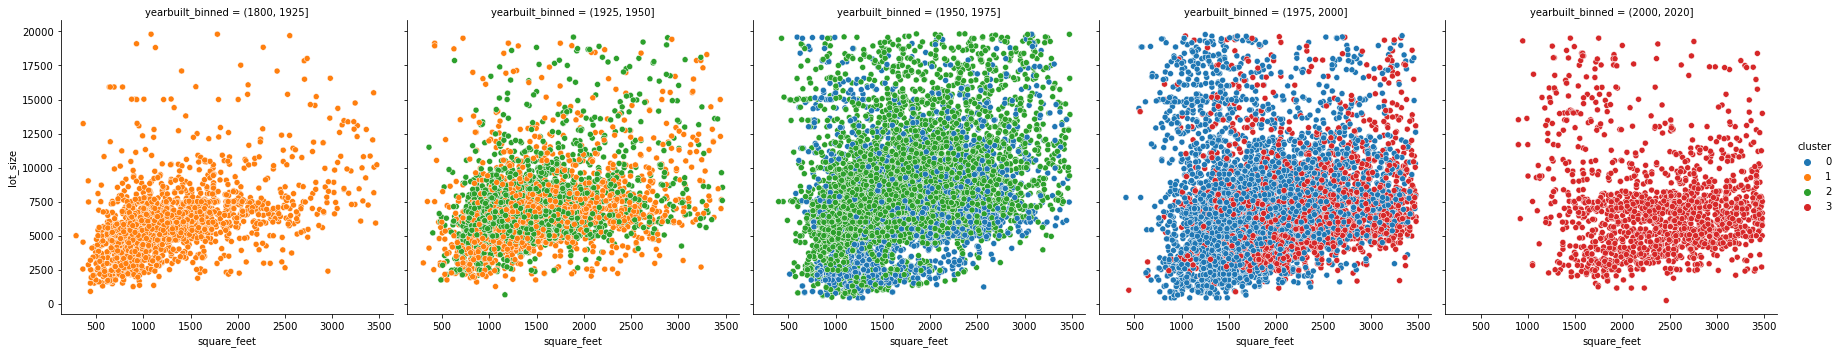

In [11]:
# Here we create the same plot as above with the clusters added in.
plot_clusters(train)

With these clusters created we now want to determine if there is any significant difference in mean logerror between these groups. We'll use an anova test between the mean logerror for each cluster.

$H_0$: The mean logerror for all four clusters is equal.
<br>
$H_a$: The mean logerror for all four clusters is not equal.

In [12]:
# Here we run an anova test on the mean logerror for each cluster.
run_stats_test_for_clusters(train)

Reject H0


We reject the null hypothesis indicating that there is a significant different in mean logerror between each cluster.

### Summary of Exploration

Here we identified the features tax assessed value, zip code, and square feet as being potential drivers of logerror. Additionally we created clusters using the features square feet, lot size, and property age, and showed that these clusters, as well as property age, may also be drivers of logerror. The visualizations produced and statistical testing results confirm that there is significant differences in mean logerror between various groups in each of these features. For this reason we will utilize these features in our machine learning models.

---

## Modeling

We should remove outliers from the training set so that they don't influence the model's behavior.

In [13]:
# Now we will remove outliers from the train dataset. We will store this data 
# with outliers removed in a separate variable since we still want to use the 
# original data with outliers for evaluating the models. The only columns with 
# significant outliers are square_feet and tax_assessed_value.
train_no_outliers = remove_outliers(train_scaled, 1.5, ['square_feet', 'tax_assessed_value'])

Now we can begin creating machine learning models. We will try creating a few models without the cluster feature and a few with it to see if it makes a difference. The performance of each model will be evaluated using the root mean squared error which will give us the average distance between the predicted values and the actual values. With this evaluation metric we will know how far off the predictions are on average.

First though, we must establish a baseline model with which to compare our models so that we may determine if our models perform better than a naive model.

In [14]:
# Here we establish a baseline model which will either the mean or median of the target, whichever 
# provides the lower RMSE score.
baseline = establish_baseline(train['logerror'])

Now with the baseline model established we can create our models.

In [15]:
# Here we will create eight different models and evaluate all of them using RMSE.
# For details refer to the model.py or model.ipynb files.
# The features used are:
#     square_feet
#     tax_assessed_value
#     zip_code, binned into two groups (those that have average logerror, and the rest)
#     property_age
models = create_models(train_no_outliers)
evaluate_models(baseline, models, train_scaled, validate_scaled, 'logerror')

,RMSE_train,RMSE_validate
baseline,0.165812,0.171276
linear_regression_no_clusters,0.165820,0.171533
tweedie_regressor_no_clusters,0.165793,0.171265
polynomial_regression_no_clusters,0.379561,0.475128
polynomial_regression_interactions_only_no_clusters,0.196310,0.201764
linear_regression_with_clusters,0.165768,0.171459
tweedie_regressor_with_clusters,0.165785,0.171255
polynomial_regression_with_clusters,0.375309,0.470333
polynomial_regression_interactions_only_with_clusters,0.199370,0.205491


It appears the tweedie regressor model with the cluster feature has the best performance overall and only slightly better than the baseline. Let's now make predictions on test.

In [16]:
# Now let's make predictions on test using the linear regression model with the cluster feature.
evaluate_on_test(models[5], test_scaled, 'logerror')

RMSE_test: 0.164386326201242


The performance on test is consistent with with train and validate.

---

## Key Takeaways and Recommendations

In exploration it was identified that the features tax assessed value, square footage, zip code, and property age are all potential drivers of logerror. However, the model results show that these features do not help produce a machine learning model that is significantly better than the baseline model. The cluster feature provided slightly improved performance, but the improvement was not significant enough to indicate that it was useful.

My official recommendation is that we need better data. Roughly half of all features are lost due to missing too many values which reduces the number of potential drivers of logerror we could analyze. We could potentially produce a more accurate model, but this would likely require a very complex model such as producing separate models for each region the properties reside in.

---

## Next Steps

Given more time I would like to analyze additional features to identify more drivers of logerror. Additionally, with more time I could attempt to produce other clustering models that may yield better results as well as producing more complex regression models that could yield more accurate results.